In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests
from scipy.stats import norm

In [2]:
# Importing Price Data


MMA_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=0,index_col=0)
C1_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=1,index_col=0)
C3_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=2,index_col=0)
F_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=3,index_col=0)
DM_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=4,index_col=0)
O2_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=5,index_col=0)
AA_P = pd.read_excel('Prices_Python_Upload2.xls',sheetname=6,index_col=0)

Mat = [MMA_P, C1_P, C3_P, F_P, DM_P, O2_P, AA_P]

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


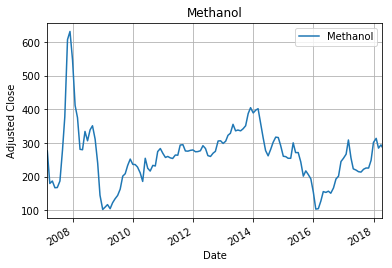

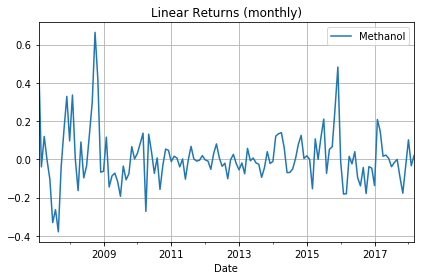

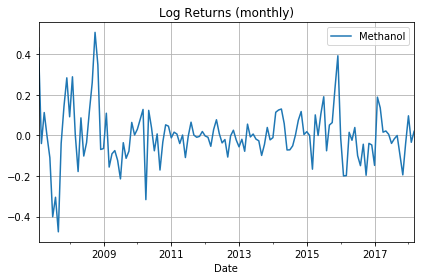

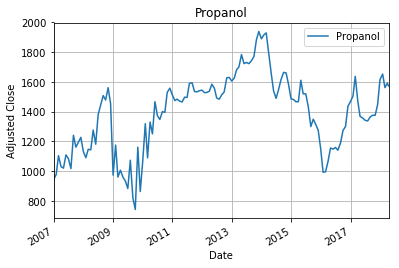

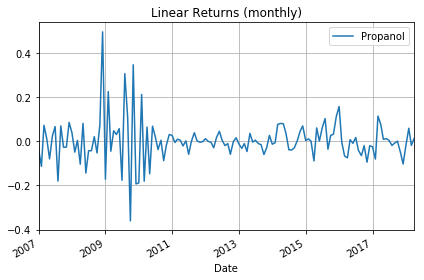

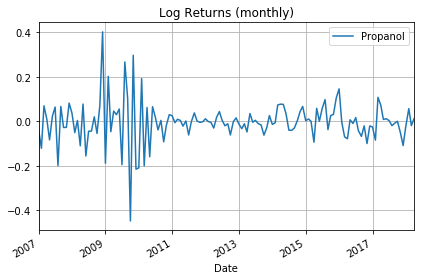

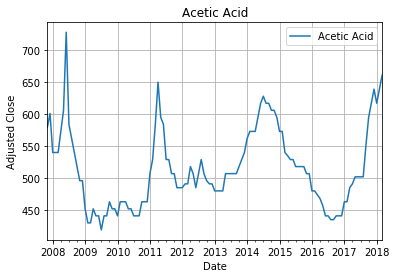

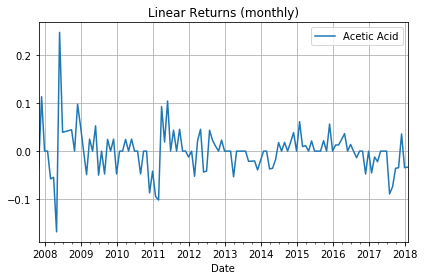

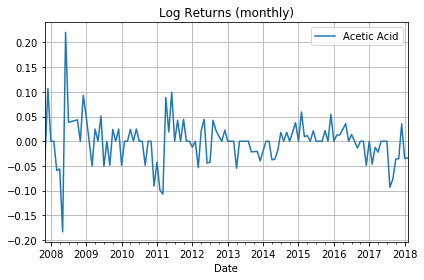

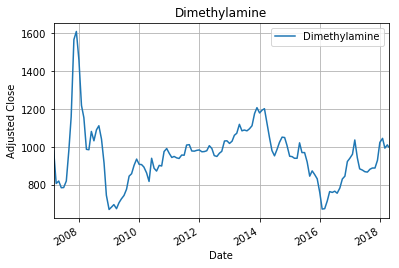

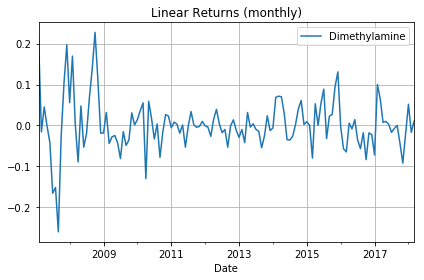

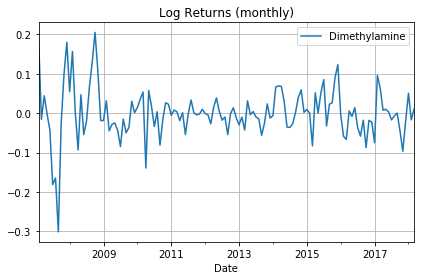

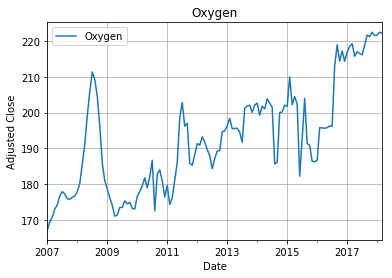

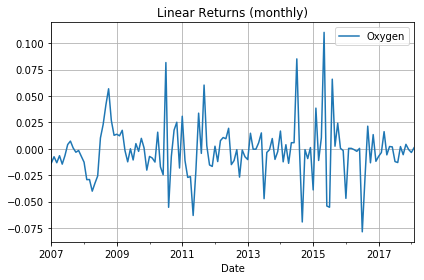

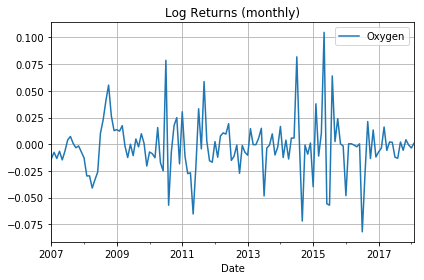

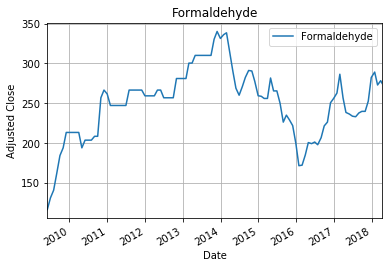

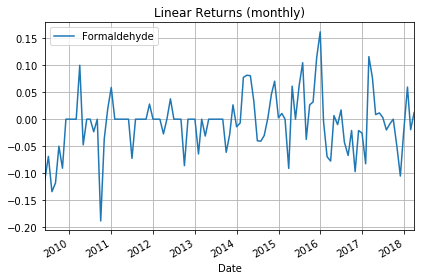

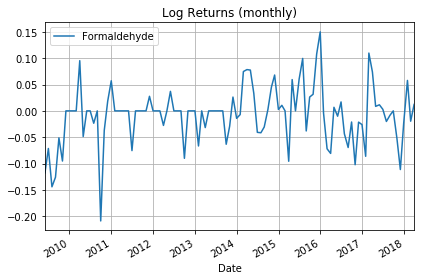

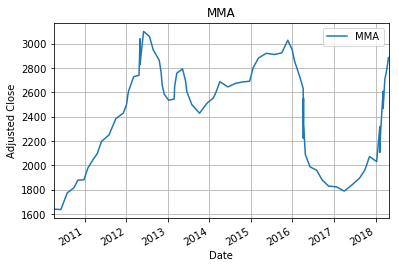

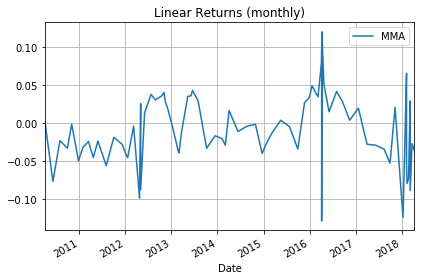

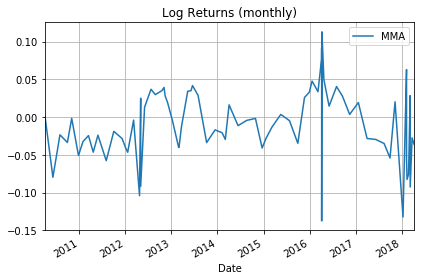

In [3]:
rlin=dict()
rlog=dict()
data=dict()

for m in Mat:
    data[m.keys().tolist()[0]] = m
    rlin[m.keys().tolist()[0]] = (m-m.shift(-1))/m.shift(-1)
    rlog[m.keys().tolist()[0]] = np.log(m/m.shift(-1))


for r in rlin:
    rlin[r] = rlin[r].dropna()
    rlog[r] = rlog[r].dropna()
    
    name = r
    plt.figure(figsize=(10,6))
    data[r].plot(title=name)
    plt.ylabel('Adjusted Close')
    plt.grid()
    
    rlin[r].plot()
    plt.title('Linear Returns (monthly)')
    plt.grid()
    plt.tight_layout()
    
    rlog[r].plot()
    plt.title('Log Returns (monthly)')
    plt.grid()
    plt.tight_layout()


/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


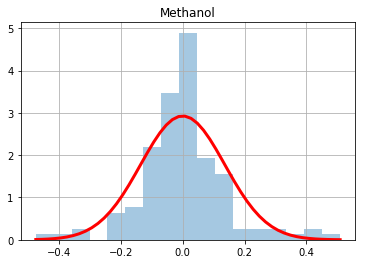

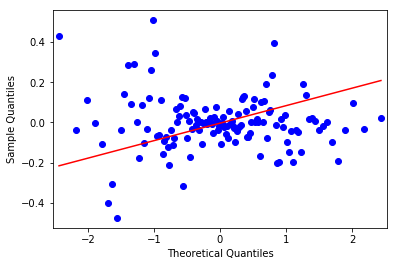

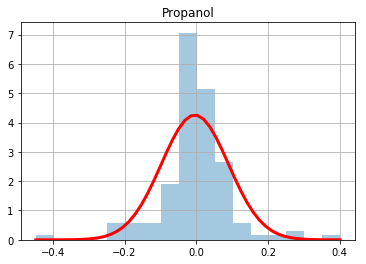

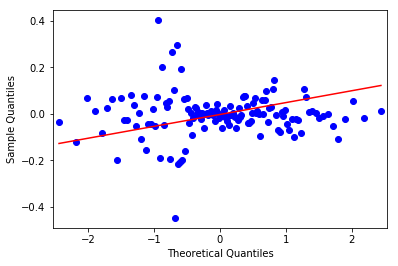

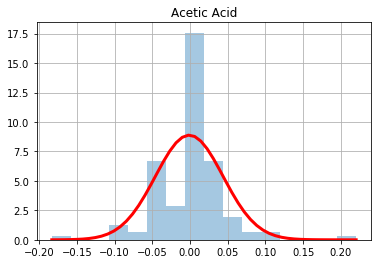

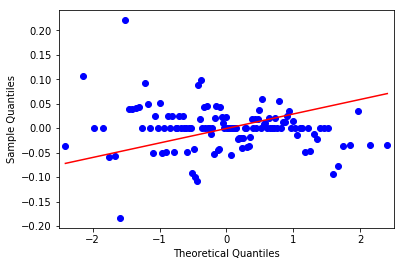

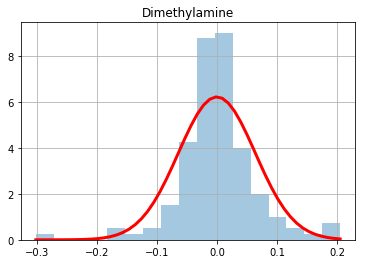

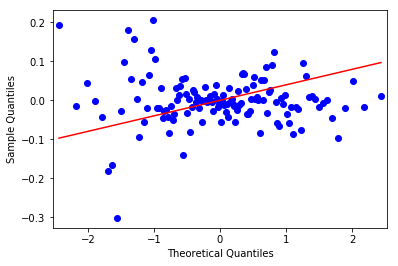

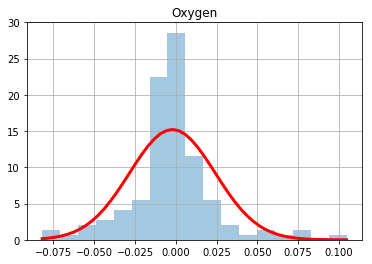

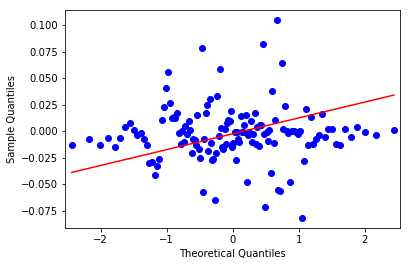

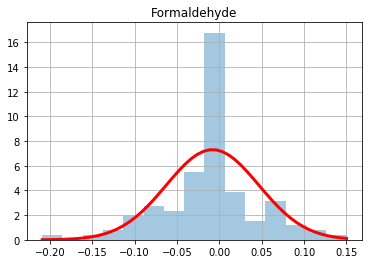

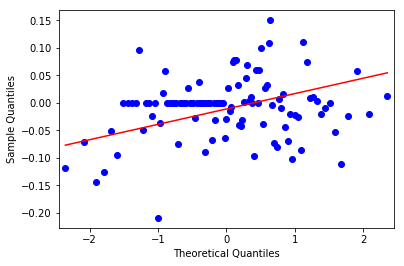

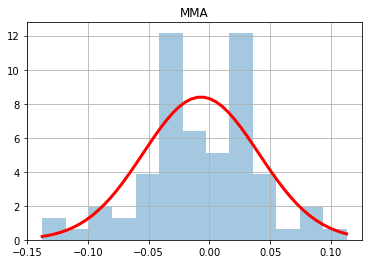

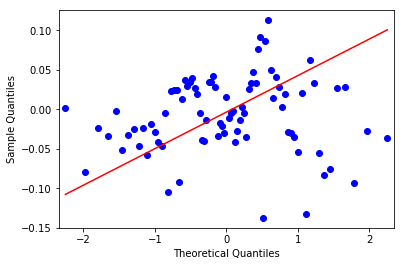

In [4]:
# Checking normal distribution

from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

for r in rlin:
    x = np.linspace(rlog[r].min(),rlog[r].max())

    plt.figure()
    param = norm.fit(rlog[r])
    rlog[r].hist(bins=int(1.5*np.sqrt(len(rlog[r]))),normed=1,alpha=0.4)
    plt.plot(x,norm.pdf(x,loc=param[0],scale=param[1]),'r-',lw=3)

    plt.figure()
    qqplot(rlog[r],line='q');


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


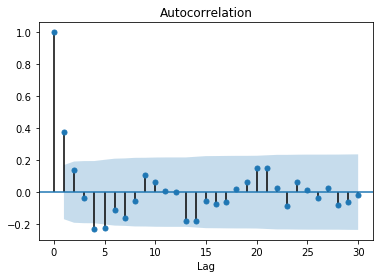

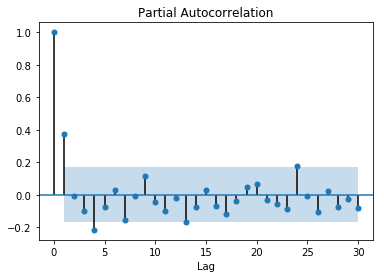

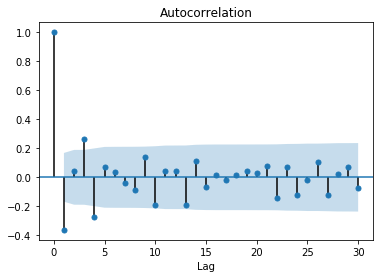

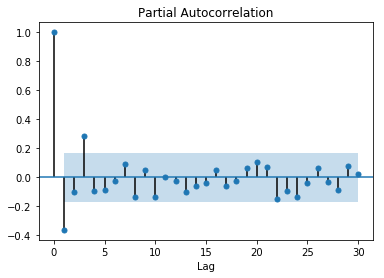

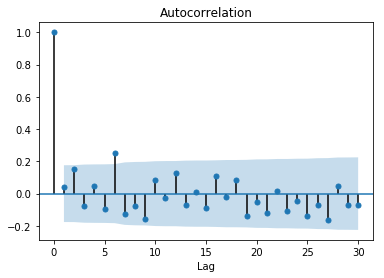

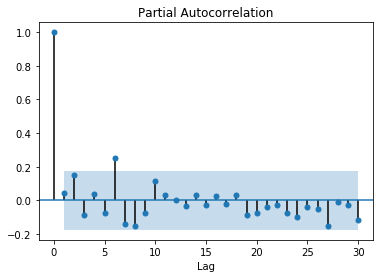

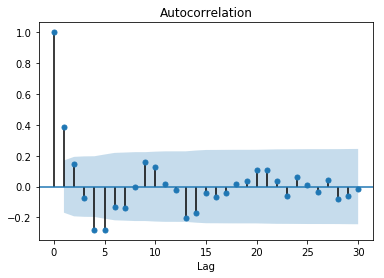

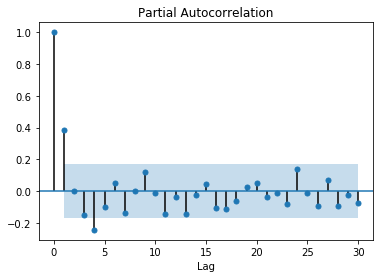

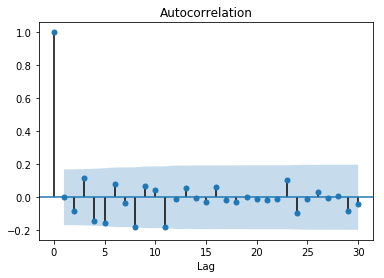

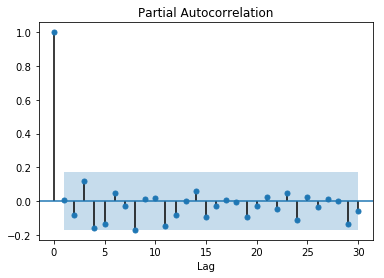

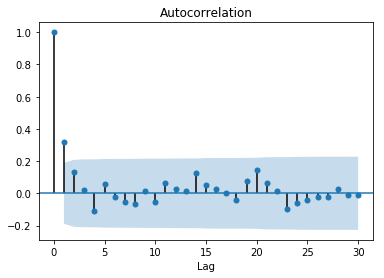

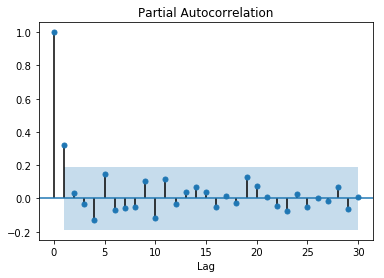

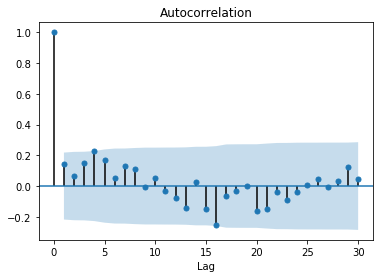

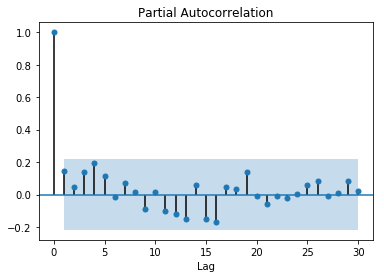

In [5]:
# Checking correlation of returns

for r in rlin:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(rlog[r],lags=min(30,len(rlog[r])));
    plt.xlabel('Lag');
    plot_pacf(rlog[r],lags=min(30,len(rlog[r])));
    plt.xlabel('Lag');

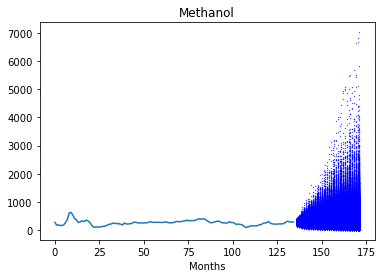

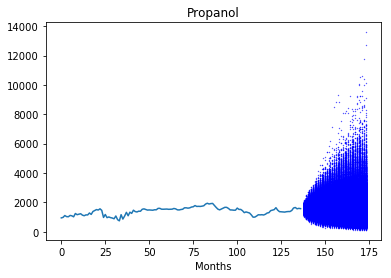

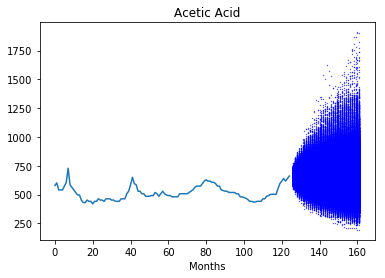

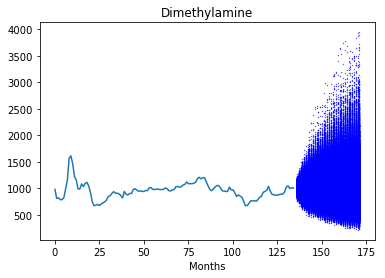

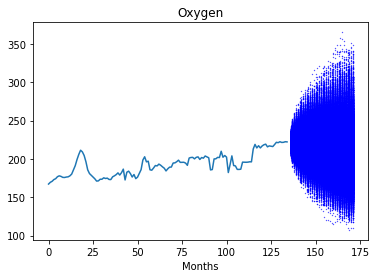

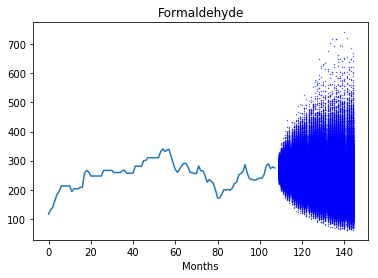

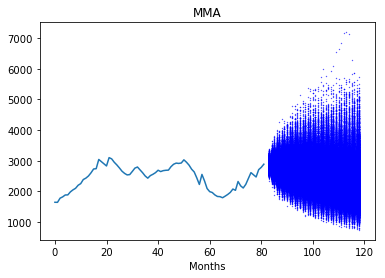

In [6]:
# Creating the Stochastic Model

PflogAll = dict()     # for recording the final price in each simulation

for r in rlin:
    plt.figure()
    plt.plot(data[r].values)
    plt.title(r)
    plt.xlabel('Months')


    N = 10000    # number of realizations
    T = 36     # simulation time horizon in months
    h = 1      # time step in months

    param = norm.fit(rlin[r])
    alpha = param[0]/h
    beta = param[1]/np.sqrt(h)

    Pflog = []   # for recording the final price in each simulation

    for n in range(0,N):
        P = data[r].iloc[-1][r]
        k = len(data[r])
        Plog = []
        klog = []
        for t in range(0,T):
            Z = norm.rvs(loc=alpha*h,scale=beta*np.sqrt(h))
            P += P*Z
            k += 1
            Plog.append(P)
            klog.append(k)
        plt.plot(klog,Plog,'b.',ms=0.6)
        Pflog.append(P)
    PflogAll[r] = Pflog


In [7]:
# Calculating Outputs
stats = dict()
for r in rlin:
    meanP = np.mean(PflogAll[r])
    medP = np.median(PflogAll[r])
    stdevP = np.std(PflogAll[r])
    ciP = norm.interval(0.7, meanP, stdevP)
    i = len(data[r])

    stats[r] = {'3. Mean Price in 3 years': np.round(meanP), 
             '2. Median Price in 3 years': np.round(medP), 
             '4. 70% Confidence Interval': np.round(ciP),
             '1. Current Price':np.round(data[r].iloc[-1][r])}
df = pd.DataFrame(data=stats)
df.T

,1. Current Price,2. Median Price in 3 years,3. Mean Price in 3 years,4. 70% Confidence Interval
Acetic Acid,661,635,660,"[467.0, 853.0]"
Dimethylamine,1000,995,1068,"[621.0, 1516.0]"
Formaldehyde,275,205,216,"[141.0, 292.0]"
MMA,2885,2248,2336,"[1640.0, 3033.0]"
Methanol,288,275,398,"[-30.0, 827.0]"
Oxygen,222,206,208,"[174.0, 243.0]"
Propanol,1573,1374,1612,"[594.0, 2629.0]"


In [8]:
# NPV Calculations Varying All

FCI = 10283219
Y1_Spend = 0.6
WC = FCI*0.15
Land = 4500000
Fixed_Cost = 15277763
Waste_Cost = -54.163074 #$/ton MMA
Plant_Eff = [0, 0, 0, 0.6, 0.8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MMA_Max = 100000
MMA_Ratio = {'Oxygen': -0.593514,
            'Methanol': -0.932982,
            'Acetic Acid': -0.011124,
            'MMA': 1,
            'Formaldehyde': -0.563184,
            'Propanol': -1.089198,
            'Dimethylamine': -0.016908}
Dep_Rate = [0, 0, 0, .1429, .2449, .1749, .1249, .0893, .0892, .0893, .0446, 0, 0, 0, 0, 0, 0, 0]
Tax = 0.4
Interest = 0.1

In [9]:
CF = np.zeros((18,N))
DCF = np.zeros((18, N))
COMd = np.zeros((18,N))
Dep = np.zeros(18)
Rev = np.zeros((18,N))
Var_Cost = np.zeros((18,N))
CF[0] = (-Land)
CF[1] = (-FCI*Y1_Spend)
CF[2] = (-FCI*(1-Y1_Spend)-WC)
for i in np.arange(3,18):
    for j in np.arange(0,N):
        Var_Cost[i][j] = Waste_Cost*MMA_Max*Plant_Eff[i]
        for d in data:
            if MMA_Ratio[d] >0:
                Rev[i][j] = PflogAll[d][j]*MMA_Ratio[d]*MMA_Max*Plant_Eff[i]
            else:
                Var_Cost[i] += PflogAll[d][j]*MMA_Ratio[d]*MMA_Max*Plant_Eff[i]
        COMd[i][j] = Var_Cost[i][j] - Fixed_Cost
        Dep[i] = Dep_Rate[i]*FCI
        CF[i][j] = (Rev[i][j]+COMd[i][j]-Dep[i])*(1-Tax)+Dep[i]
    if i>16:
        CF[i] = CF[i] + WC + Land
NPV = np.zeros(N)
for i in np.arange(0,N):
    for j in np.arange(0,18):
        DCF[j][i] = CF[j][i]/(1+Interest)**j
        NPV[i] += DCF[j][i]  

In [10]:
DCF0 = DCF[0][0]
DCF1 = DCF[1][0]
DCF2 = DCF[2][0]

NPV_i = DCF0 + DCF1 + DCF2
for j in np.arange(3,18):
    Rev_i = 0
    Var_Cost_i = Waste_Cost*MMA_Max*Plant_Eff[j]
    Comd_i = 0
    Dep_i = 0
    CF_i = 0
    DCF_i = 0
    for d in data:
        if d == "MMA":
            Rev_i = data[d].iloc[-1][d]*MMA_Ratio[d]*MMA_Max*Plant_Eff[j]
        else:
            Var_Cost_i += data[d].iloc[-1][d]*MMA_Ratio[d]*MMA_Max*Plant_Eff[j]
    COMd_i = Var_Cost_i - Fixed_Cost
    Dep_i = Dep_Rate[j]*FCI
    CF_i = (Rev_i+COMd_i-Dep_i)*(1-Tax)+Dep_i
    if j == 17:
        CF_i = CF_i + Land + WC
    DCF_i = CF_i/(1+Interest)**j
    NPV_i += DCF_i

0.4466


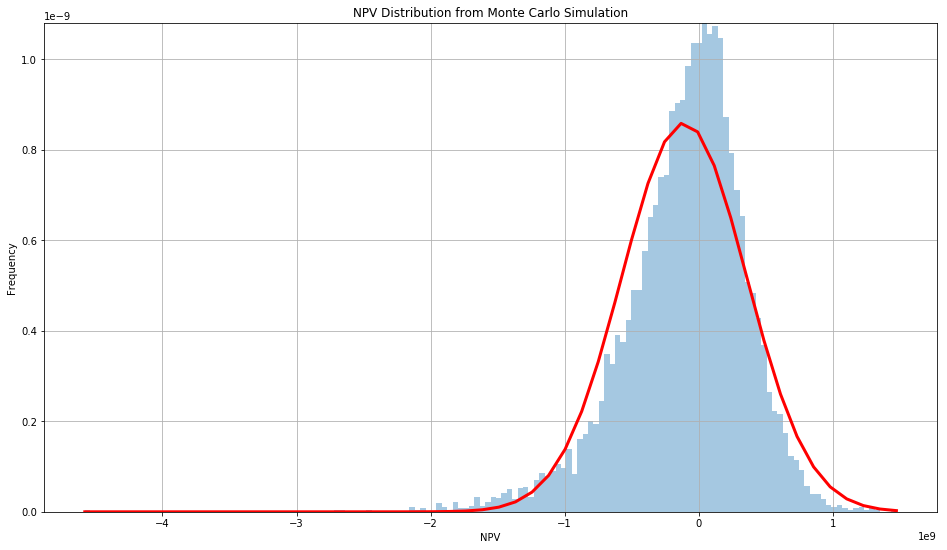

In [19]:
NPVdf = pd.DataFrame(NPV)
x = np.linspace(NPV.min(),NPV.max())
counter = 0
for i in np.arange(0,N):
    if NPV[i] > 0:
        counter +=1
prob_profit = counter/N
print(prob_profit)

param = norm.fit(NPVdf)
NPVdf.hist(bins=int(1.5*np.sqrt(len(NPVdf))),normed=1,alpha=0.4)
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(x,norm.pdf(x,loc=param[0],scale=param[1]),'r-',lw=3)
plt.title('NPV Distribution from Monte Carlo Simulation')
plt.xlabel('NPV')
plt.ylabel('Frequency')


In [12]:
stats = dict()
i = 'Overall'
meanP = np.mean(NPV)
medP = np.median(NPV)
stdevP = np.std(NPV)
ciP = norm.interval(0.7, meanP, stdevP)
base = NPV_i  
pd.options.display.float_format = '{:,.2f}'.format
stats[i] = {'3. Mean NPV': meanP, 
         '2. Median NPV': medP, 
         '4. 70% Confidence Interval': np.round(ciP),
         '1. Current NPV': base}
df = pd.DataFrame(data=stats)
df

,Overall
1. Current NPV,"120,068,272.20"
2. Median NPV,"-50,795,473.19"
3. Mean NPV,"-109,366,502.05"
4. 70% Confidence Interval,"[-590726413.0, 371993409.0]"


In [13]:
# NPV Varying Single Materials
NPV_S = dict()
Var_S = dict()

for d in data:
    if d == "MMA":
        NPVlog = np.zeros(N)
        for i in np.arange(0,N):
            NPVlog[i] += DCF0 + DCF1 + DCF2
            for j in np.arange(3,18):
                Rev_S = 0
                Var_Cost_S = Waste_Cost*MMA_Max*Plant_Eff[j]
                Comd_S = 0
                Dep_S = 0
                CF_S = 0
                DCF_S = 0
                Rev_S = PflogAll[d][i]*MMA_Ratio[d]*MMA_Max*Plant_Eff[j]
                for e in data: 
                    if e != d:
                        Var_Cost_S += data[e].iloc[-1][e]*MMA_Ratio[e]*MMA_Max*Plant_Eff[j]
                COMd_S = Var_Cost_S - Fixed_Cost
                Dep_S = Dep_Rate[j]*FCI
                CF_S = (Rev_S+COMd_S-Dep_S)*(1-Tax)+Dep_S
                if j == 17:
                    CF_S = CF_S + Land + WC
                DCF_S = CF_S/(1+Interest)**j
                NPVlog[i] += DCF_S
        NPV_S[d] = NPVlog
    else:
        NPVlog = np.zeros(N)
        for i in np.arange(0,N):
            NPVlog[i] += DCF0 + DCF1 + DCF2
            for j in np.arange(3,18):
                Rev_S = 0
                Var_Cost_S = Waste_Cost*MMA_Max*Plant_Eff[j]
                Comd_S = 0
                Dep_S = 0
                CF = 0
                DCF = 0
                for f in data:
                    if MMA_Ratio[f] >0: 
                        Rev_S = data[f].iloc[-1][f]*MMA_Ratio[f]*MMA_Max*Plant_Eff[j]
                    else: 
                        if d == f:
                            Var_Cost_S += PflogAll[f][i]*MMA_Ratio[f]*MMA_Max*Plant_Eff[j]
                        else:
                            Var_Cost_S += data[f].iloc[-1][f]*MMA_Ratio[f]*MMA_Max*Plant_Eff[j]
                COMd_S = Var_Cost_S - Fixed_Cost
                Dep_S = Dep_Rate[j]*FCI
                CF_S = (Rev_S+COMd_S-Dep_S)*(1-Tax)+Dep_S
                if j == 17:
                    CF_S = CF_S + Land + WC
                DCF_S = CF_S/(1+Interest)**j
                NPVlog[i] += DCF_S
    NPV_S[d] = NPVlog

In [14]:
stats_S = dict()
for r in rlin:
    meanP_S = np.mean(NPV_S[r])
    medP_S = np.median(NPV_S[r])
    stdevP_S = np.std(NPV_S[r])
    ciP7_S = norm.interval(0.7, meanP_S, stdevP_S)
    ciP9_S = norm.interval(0.9, meanP_S, stdevP_S)
    base = NPV_i 

    stats_S[r] = {'3. Mean NPV': np.round(meanP_S,0), 
             '2. Median NPV': np.round(medP_S,0), 
             '4. 70% Confidence Interval': np.round(ciP7_S,0),
             '5. 90% Confidence Interval': np.round(ciP9_S,0),
             '1. Base NPV':base}
df = pd.DataFrame(data=stats_S)
df

,Acetic Acid,Dimethylamine,Formaldehyde,MMA,Methanol,Oxygen,Propanol
1. Base NPV,"120,068,272.20","120,068,272.20","120,068,272.20","120,068,272.20","120,068,272.20","120,068,272.20","120,068,272.20"
2. Median NPV,"120,169,031.00","120,100,047.00","133,886,026.00","-103,427,422.00","124,438,216.00","123,437,695.00","195,873,832.00"
3. Mean NPV,"120,073,759.00","119,663,380.00","131,625,764.00","-72,511,623.00","84,029,326.00","122,970,811.00","105,191,714.00"
4. 70% Confidence Interval,"[119320364.0, 120827153.0]","[117009039.0, 122317722.0]","[116737950.0, 146513579.0]","[-317033262.0, 172010015.0]","[-56247395.0, 224306047.0]","[115790267.0, 130151356.0]","[-283808358.0, 494191785.0]"
5. 90% Confidence Interval,"[118878097.0, 121269420.0]","[115450853.0, 123875907.0]","[107998316.0, 155253212.0]","[-460575447.0, 315552200.0]","[-138594410.0, 306653062.0]","[111575053.0, 134366570.0]","[-512164100.0, 722547527.0]"


In [15]:
NPV_i = DCF0 + DCF1 + DCF2
for j in np.arange(3,18):
    Rev_i = 0
    Var_Cost_i = Waste_Cost*MMA_Max*Plant_Eff[j]
    Comd_i = 0
    Dep_i = 0
    CF_i = 0
    DCF_i = 0
    for d in data:
        if d == "MMA":
            Rev_i = data[d].iloc[-1][d]*MMA_Ratio[d]*MMA_Max*Plant_Eff[j]
        else:
            Var_Cost_i += data[d].iloc[-1][d]*MMA_Ratio[d]*MMA_Max*Plant_Eff[j]
    COMd_i = Var_Cost_i - Fixed_Cost
    Dep_i = Dep_Rate[j]*FCI
    CF_i = (Rev_i+COMd_i-Dep_i)*(1-Tax)+Dep_i
    if j == 17:
        CF_i = CF_i + Land + WC
    DCF_i = CF_i/(1+Interest)**j
    NPV_i += DCF_i

In [16]:
NPV_i

120068272.20124097